# Logistic Regression

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import libraries
from __future__ import absolute_import, division, print_function

# Ignore warnings
import warnings
#warnings.filterwarnings('ignore')

import sys
sys.path.append('/Users/omojumiller/mycode/tools')

import numpy as np
import pandas as pd
import scipy.stats as st
from tools import plot_features_by_target


# Use CPickle if available
try:
   import cPickle as pickle
except:
   import pickle

# Graphing Libraries
import matplotlib.pyplot as pyplt
import seaborn as sns
sns.set_style("white")  

# Configure for presentation
np.set_printoptions(threshold=50, linewidth=50)
import matplotlib as mpl
mpl.rc('font', size=16)

from IPython.display import display

In [3]:
from sklearn import datasets

# Load the Boston Housing dataset into the city_data variable
data = datasets.load_boston()

# Initialize the housing prices and housing features
housing_prices = data.target
housing_features = data.data

In [4]:
print(data.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [5]:
cols = 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'

In [31]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

df = pd.DataFrame(scaler.fit_transform(housing_features), columns=cols)
df['price'] = housing_prices

In [35]:
x_vars_1 = ['AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
x_vars_2 = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM']
y_vars=['price']

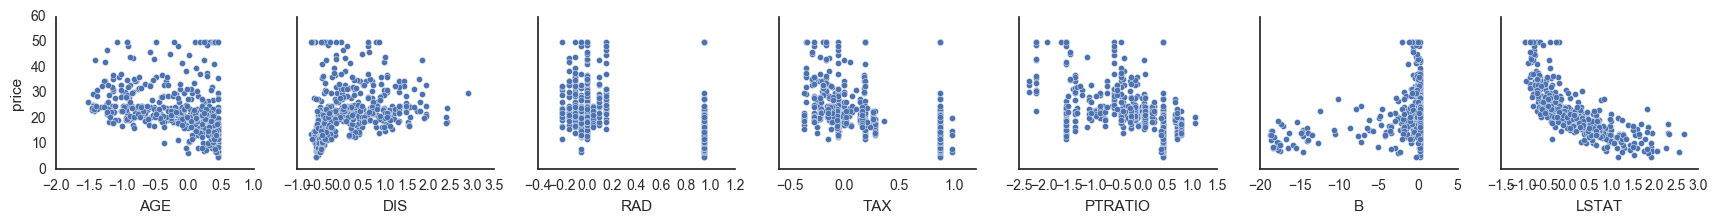

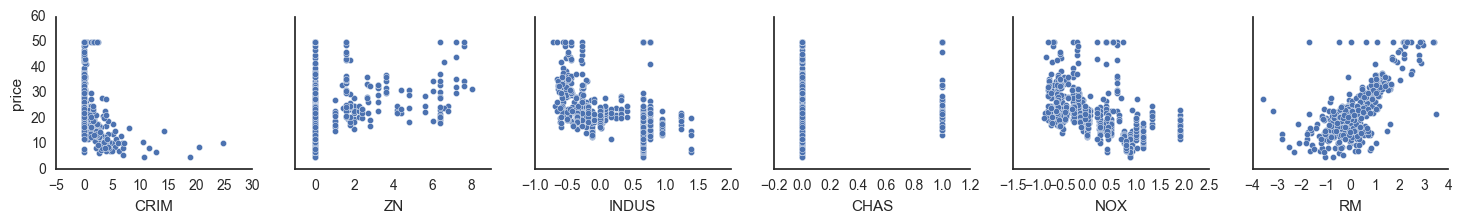

In [36]:
plot_features_by_target(df, x_vars_1, y_vars)
plot_features_by_target(df, x_vars_2, y_vars)

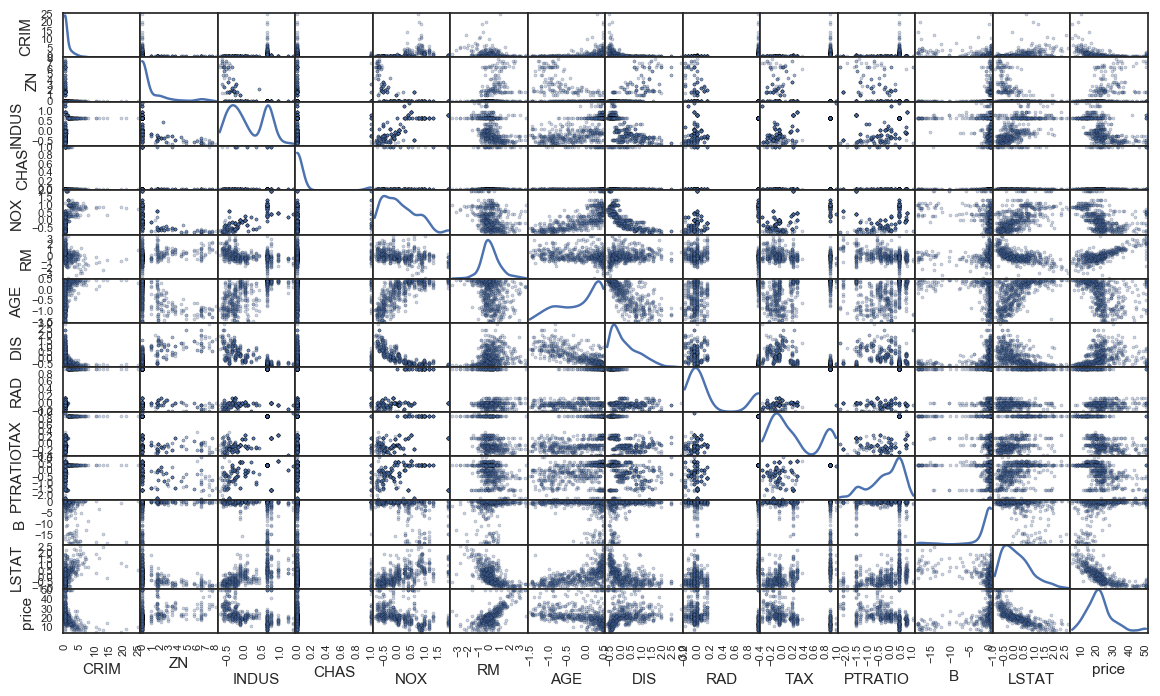

In [37]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(df, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

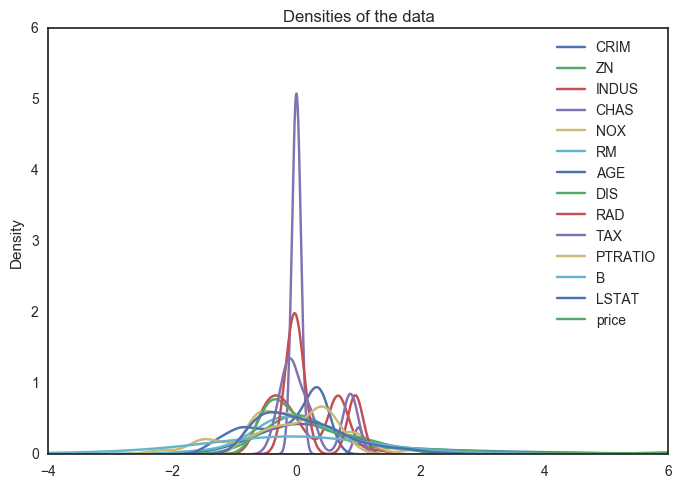

In [42]:
# plot densities of the data
for col in df.columns:
    ax = df[col].plot.kde()
    
ax.set_xlim(-4, 6)
plt.legend();
plt.grid(False);
plt.title('Densities of the data');